In [13]:
from pathlib import Path

import numpy as np
import torch

from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook, trange

import itertools

import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

In [14]:
debug = True

# prepare data

In [15]:
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule

In [16]:
# prepare validation data
cfg = combine_cfgs('../src/config/experiments/algonauts2021_i3d_flow.yml')
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

val_indices = dm.val_dataset.indices

cache_path = Path('/data_smr/huze/.cache/val_fmris.pt')

if cache_path.exists():
    val_fmris = torch.load(cache_path)
else:
    val_fmris = [dm.dataset_train_val.__getitem__(i)[1] for i in tqdm(val_indices)]
    val_fmris = np.stack(val_fmris, 0)
    val_fmris = torch.tensor(val_fmris)
    torch.save(val_fmris, cache_path)

In [17]:
voxel_masks = np.load(dm.dataset_train_val.root_dir.joinpath(Path('processed/voxel_masks.npy')))

In [18]:
from src.utils.visulization import save_as_nii

reliable_voxel_mask_mean_sub = voxel_masks.sum(0)
reliable_voxel_mask_mean_sub[reliable_voxel_mask_mean_sub > 0] = 1
reliable_voxel_mask_mean_sub = reliable_voxel_mask_mean_sub.astype(np.int8)
reliable_voxel_mask_path = Path('./tmp/reliable_voxel_mask.nii')
save_as_nii('./tmp/example.nii', reliable_voxel_mask_path, reliable_voxel_mask_mean_sub)
# reliable_voxel_mask make a more accurate volume to surface mapping

In [19]:
predictions_dict = {
    # from previous project, notebook 'plot mc fi score, maybe final'
    'Baseline,VGG16 2D + LSTM,NoEnsemble,layer=(x1,x2,x3,x4,x5),pathway=cascade,roi=WB': Path(
        '/data_smr/huze/projects/my_algonauts/predictions/bc4bd42bc70d409daebe27f2c0fae255/WB.pt'),
    # from notebook 1.
    'Baseline,Inflated 3D Resnet,RGB stream,NoEnsemble,layer=(x1,x2,x3,x4),pathway=topdown,roi=WB': Path(
        "/data/huze/ray_results/algonauts2021/algonauts2021_i3d_rgb-multi_layer/run_single_tune_config_575a8_00066_66_DATASET.ROI=WB,MODEL.BACKBONE.LAYERS=_'x1', 'x2', 'x3', 'x4'_,MODEL.BACKBONE.LAYER_PATHWAYS=_2022-02-26_14-18-59/prediction.npy"),
    # from notebook 900.
    'Best,Inflated3D,HierarchicalEnsemble,RGB steram + FLOW stream,ROIxkROI': Path('/data/huze/ray_results/algonauts2021/ensemble_outputs/he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble-prediction.pt'),
}

# from notebook 900. submission output
submission_scores = [0.2318629775, 0.3216765311, 0.3823963473]
submission_score_dict = {k: v for k, v in zip(list(predictions_dict.keys()), submission_scores)}

In [20]:
predictions_dict = {k: path for k, path in predictions_dict.items() if path.exists()}
assert len(predictions_dict) > 1

In [21]:
from src.utils.visulization import my_nice_nilearn_plot

In [22]:
from matplotlib import pyplot as plt
from nilearn import plotting
import pandas as pd
from src.utils.visulization import save_voxel_data_as_subject_mean_nii
from src.utils.metrics import vectorized_correlation

fsaverage = 'fsaverage'
# fsaverage = 'fsaverage5'
cmap = 'PuOr'
vmax = 0.5
inflate = True

tab_data = []
for name, path in list(predictions_dict.items())[:]:
    if path.name.endswith('.pt'):
        prediction = torch.load(path).float()
    else:
        prediction = torch.tensor(np.load(path)).float()

    voxel_score = vectorized_correlation(prediction[val_indices], val_fmris)
    voxel_score = voxel_score.numpy()
    mean_score = voxel_score.mean()
    
    submission_score = submission_score_dict[name]

    tmp_nii_path = Path(f'tmp/VOXEL SCORE ^-^ {name}.nii')
    example_nii_path = Path('tmp/example.nii')
    
    print(name)
    save_voxel_data_as_subject_mean_nii(voxel_masks, voxel_score, example_nii_path, tmp_nii_path)
    
    nice_image = my_nice_nilearn_plot(
        nii_img_path=str(tmp_nii_path),
        mask_img_path=str(reliable_voxel_mask_path),
        tmp_dir='./tmp/voxel score figs',
        dpi=350,
        fsaverage=fsaverage,
        inflate=inflate,
        fill_nan_value=0,
        alpha=1.,
        darkness=.5,
        vmax=vmax,
        cmap=cmap,
        bg_on_data=True,
    )
        
    save_path = os.path.join('figures', f'VOXEL SCORE ^-^ val_score={mean_score:.4f},test_score={submission_score:.4f},{name}.jpg')
    nice_image.save(save_path, quality=95)
    
    tab_data.append({
        'NAME': name,
        'WB SCORE': f'{mean_score:.4f}/{submission_score:.4f}'
    })
tab_df = pd.DataFrame(tab_data)

Baseline,VGG16 2D + LSTM,NoEnsemble,layer=(x1,x2,x3,x4,x5),pathway=cascade,roi=WB


/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


Baseline,Inflated 3D Resnet,RGB stream,NoEnsemble,layer=(x1,x2,x3,x4),pathway=topdown,roi=WB


/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


Best,Inflated3D,HierarchicalEnsemble,RGB steram + FLOW stream,ROIxkROI


/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


In [30]:
np.save('./tmp/best_voxel_score.npy', voxel_score)

In [23]:
tab_df

,NAME,WB SCORE
0,"Baseline,VGG16 2D + LSTM,NoEnsemble,layer=(x1,...",0.0987/0.2319
1,"Baseline,Inflated 3D Resnet,RGB stream,NoEnsem...",0.1478/0.3217
2,"Best,Inflated3D,HierarchicalEnsemble,RGB stera...",0.1798/0.3824


In [24]:
tab_df.to_csv('./tables/Table 201 - Baselines.csv')

In [25]:
from src.utils.visulization import make_horizontal_color_bar

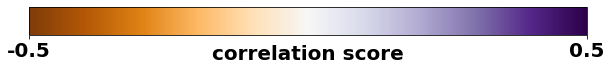

In [26]:
cbar_label_text = 'correlation score'
cbar = make_horizontal_color_bar(cmap, vmax, -vmax, cbar_label_text=cbar_label_text, offset=-0.7)
plt.savefig('./figures/colorbar VOXEL SCORE.pdf')
plt.show()

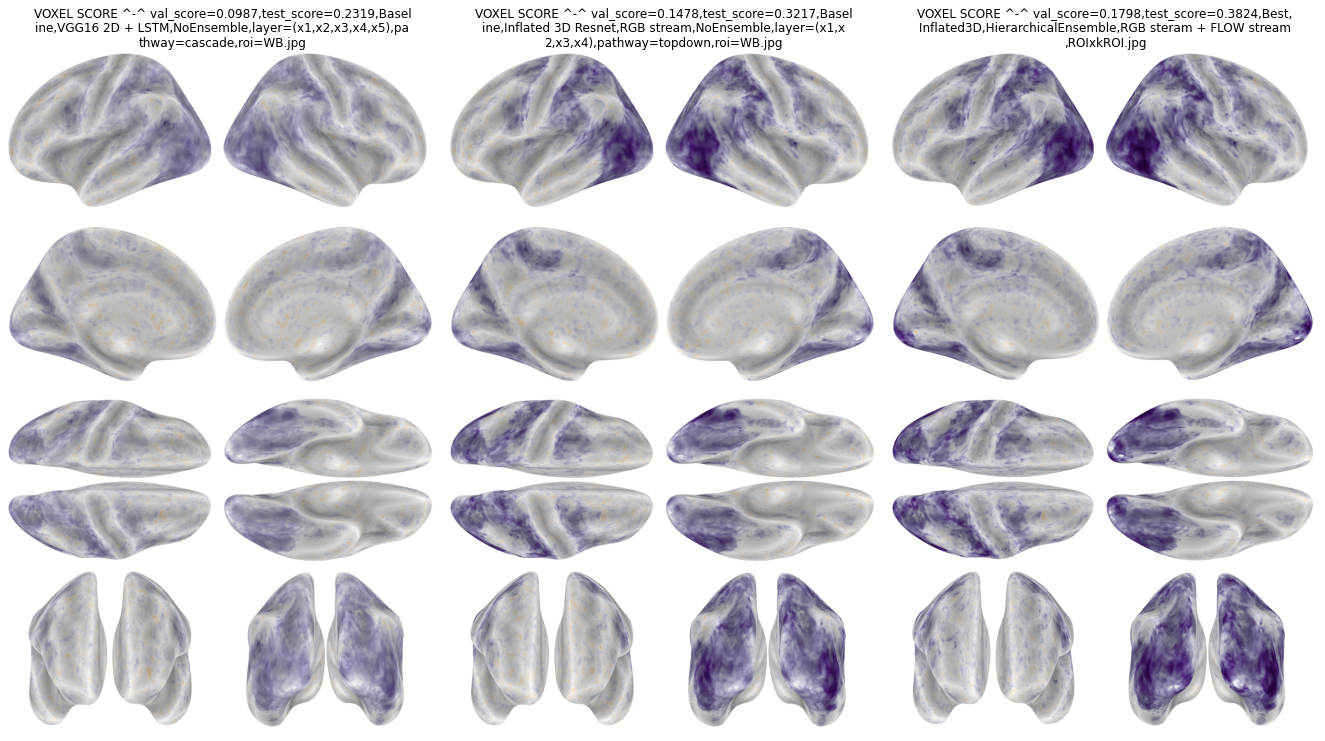

In [27]:
from PIL import Image
import re

fig_dir = Path('./figures')

for fill_text in ['VOXEL SCORE']:
    filter_texts = ['PLACEHOLDER ^-^']
    # fill_text = 'MOTION CORRELATION'
    row_paths = []
    for filter_text in filter_texts:
        filter_text = filter_text.replace('PLACEHOLDER', fill_text)
        paths = sorted([path for path in list(fig_dir.iterdir()) if filter_text in path.name])
        row_paths.append(paths)

    ncols = len(row_paths[0])
    nrows = len(row_paths)
    size = 10

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*size*0.618, nrows*size))

    axes = axs.flatten()
    for ax in axes:
        ax.axis('off')

    for i, paths in enumerate(row_paths):
        for j, path in enumerate(paths):
            ax = axs[i, j] if nrows > 1 else axs[j]
            ax.imshow(Image.open(path))
            
            # insert \n each n characters
            title = re.sub("(.{56})", "\\1\n", path.name, 0, re.DOTALL)
            ax.set_title(title)
            
            
    plt.tight_layout()
    plt.savefig(fig_dir.joinpath(Path(f'subplots {fill_text}.pdf')))
    plt.show()